# Grid Search for Cross Validation

This notebook implements a parallel and a non-parallel version of a grid search for cross-validated parameters. The procedure generally works as follows:

1. Randomly split the data set into *k* training and test folds.
2. Create a grid of parameters for the model being used.
3. For each parameter from the grid, train the model on the training set and calculate the cross validation score obtained from the test set for each of the *k* folds.
4. For each parameter, calculate the average score over the *k* folds.
5. Choose the parameter that achieves the highest average score.

Since the calculations of the scores for models with different parameter values are independent, this procedures is embarrassingly parallel. In particular, since the non-parallel version simply loops over all parameters and then loops over all *k* folds for each parameter, the speed gains from the parallel code are expected to be substantial.

As an example, we use the above procedure to find an optimal value for the parameter *alpha* used when appying the LASSO (Least Absolute Shrinkage and Selection Operator) estimator. Note that the functions in this notebook are written in a rather generic way which allows to apply the procedure to any linear model from the sklearn.linear_model class that requires only one input parameter.

## Functions

In this section, we define the functions needed to execute the grid search for cross validated parameters both in a parallel and non-parallel fashion. Before we define the functions, we import the required modules.

In [1]:
import numpy as np
import os
from sklearn.externals import joblib
from ipyparallel import Client
import timeit
%matplotlib inline
import matplotlib.pyplot as plt

First, we define a function that creates cross validation training and test sample indices.

In [2]:
def cv_splits(x, iterations, test_size, random_seed=444):
    """Create random indices for cross validation training and test samples.

    Args:
        x : numpy array
            Data used to determine the size of the training and split samples.

        iterations : int
            Number of folds to be generated from data.

        test_size : float
            Share of the data that is used for testing.

        random_seed : int
            Random seed used when randomly drawing indices.

    """

    # Set random seed for replicability.
    np.random.seed(random_seed)

    # Create lists to store indices.
    train = list(range(iterations))
    valid = list(range(iterations))

    for i, j in zip(train, valid):

        # Draw indices of training set randomly.
        train[i] = np.random.choice(
            range(x.shape[0]), round(x.shape[0] * (1 - test_size))
        )

        # Draw indices of test set randomly.
        valid[j] = np.random.choice(
            range(x.shape[0]), round(x.shape[0] * test_size)
        )

    return train, valid

Next, we use the above function to define a second function that splits a given data set into *k*  training and test samples. These are then saved on the hard drive as pickle objects.

In [3]:
def cross_validation_samples(x, y, iterations=10, test_size=0.25):
    """Create cross validation splits. The splits are then save them on the hard
    drive.

    Args:
        x : numpy array
            Regressors used to predict a target.

        y : numpy array
            Observations of target values.

        iterations : int
            Number of folds to be generated from data. The default value is set
            to 10.

        test_size : float
            Share of the data that is used for testing. The default value is
            set to 0.25.

    """

    # Create empty list to store file names of cross validation split samples.
    samples = []

    # Create cross validation splits.
    training, validation = cv_splits(x, iterations, test_size=test_size)

    # Define generic name for split files.
    name = "split_%02d.pkl"

    # Save splits on hard drive.
    for i, train, valid in zip(list(range(iterations)), training, validation):
        
        # Create a sample split using the indices defined above.
        split = (x[train], y[train], x[valid], y[valid])

        # Define name for current split.
        split_name = name % i

        # Create path to save split in working directory.
        cv_samples = os.path.abspath(split_name)

        # Save split as a pickle object.
        joblib.dump(split, cv_samples)

        # Save file name in list.
        samples.append(cv_samples)

    return samples

Next, we define a score function. This function makes use of the score function implemented in scikit learn. Note that the model parameter can be any generic model from the sklearn.linear_model class that takes one parameter as an argument.

In [4]:
def score(cv_samples, model, par):
    """Calculate the cross validation score for a model on given cross
    validation samples.

    Args:
        cv_samples : numpy array
            Cross validation training and test samples.

        model : scikit-learn estimator object
            Object used to fit the data.

        par : int, float
            Model specific paramter used in the estimation.

    """

    # Import module here for parallelisation purposes.
    from sklearn.externals import joblib

    # Load cross validation splits from hard drive.
    x_train, y_train, x_valid, y_valid = joblib.load(cv_samples, mmap_mode='c')

    # Set parameters for model and fit the model to the data.
    reg = model(par)
    reg.fit(x_train, y_train)

    return reg.score(x_valid, y_valid)

Based thereon, we can now define a function that calculates the scores of the model over a given grid of parameters and a given set of cross validation samples.

In [5]:
def cross_validate(model, cv_samples, grid):
    """Calculate cross validation scores for given model and samples over
    different parameter combinations.

    Args:
        model : scikit-learn estimator object
            Object used to fit the data.

        cv_samples : numpy array
            Cross validation training and test samples.

        grid : numpy array
            Grid of parameters used to estimate the model.

    """

    # Create empty list to store scores.
    scores = []

    for par in grid:
        # Create empty list to save scores for each split.
        split_score = []

        for i, file in enumerate(cv_samples):
            # Calculate cross validation scores for splits.
            split_score.append(score(file, model, par))

        scores.append(split_score)

    return grid, scores

This process can be executed in parallel making use of the load_balanced view from ipyparallel as follows.

In [6]:
def cross_validate_parallel(lb_view, model, cv_samples, grid):
    """Calculate cross validation scores for given model and samples over
    different parameter combinations.

    Args:
        lb_view : ipyparallel client object
            Load balanced client from ipyparallel used to execute parallel
            computation.

        model : scikit-learn estimator object
            Object used to fit the data.

        cv_samples : numpy array
            Cross validation training and test samples.

        grid : numpy array
            Grid of parameters used to estimate the model.

    """

    # Create empty list to store scores.
    scores = []

    for par in grid:
        # Create empty list to save scores obtained for each split.
        split_score = []

        for j, file in enumerate(cv_samples):
            # Calculate cross validation scores for splits.
            split_score.append(lb_view.apply(score, file, model, par))

        scores.append(split_score)

    return grid, scores

Lastly, we define a function that returns the parameter with the highest average cross validation score.

In [7]:
def return_opt_cv_par(grid, scores, parallel):
    """Return the return the parameter with the highest average cross validation
    score.

    Args:
        grid : numpy array
            Grid of parameters used for the grid search.

        scores : numpy array
            Scores obtained from the cross validation.
        
        parallel : boolean
            Indicate whether scores were obtained from parallel or non-parallel
            grid search.

    """

    # Create empty list to store mean scores.
    mean_scores = []

    if parallel is True:
        for par, split in zip(grid, scores):

            # Read scores from AsyncResult object.
            split_scores = [score.get() for score in split if score.ready()]
            if len(split_scores) == 0:
                continue

            # Calculate mean score over splits and save the resulting number.
            mean_scores.append((np.mean(split_scores), par))
  
        # Find the parameter with the highest cross validation score.
        opt_par = sorted(mean_scores, reverse=True, key=lambda x: x[0])[:1]

        print(
            'The parameter {} achieves the highest average cross validation'
            ' score given by {}. Note that this might change if the process'
            ' has not finished yet.'.format((opt_par[0][1]), opt_par[0][0])
        )

    else:
        for par, split in zip(grid, scores):

            # Read scores.
            split_scores = [score for score in split]

            # Calculate mean score over splits and save the resulting number.
            mean_scores.append((np.mean(split_scores), par))

        # Find the parameter with the highest cross validation score.
        opt_par = sorted(mean_scores, reverse=True, key=lambda x: x[0])[:1]

        print(
            'The parameter {} achieves the highest average cross validation'
            ' score given by {}.'.format((opt_par[0][1]), opt_par[0][0])
        )

## Application

We now apply the functions to obtain the optimal paramter for Lasso when applied to the diabetes test data set from the scikitlearn library.

In [8]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

We can now split the sample using the function defined above.

In [9]:
splits = cross_validation_samples(
    diabetes.data, diabetes.target, iterations=10
)

**To be able to execute the following code in parallel, first go to the "iPython Clusters" tab and start a local cluster.**

In [10]:
client = Client()
lb_view = client.load_balanced_view()

Now, we define the Lasso estimator and a grid of parameters for the grid search.

In [11]:
from sklearn.linear_model import Lasso
model = Lasso
lasso_params = np.logspace(-4, -0.5, 500)

Let us first apply the non-parallel version of the cross validate function.

In [12]:
parameters, scores = cross_validate(model, splits, lasso_params)

In [13]:
return_opt_cv_par(parameters, scores, False)

The parameter 0.004746272898439346 achieves the highest average cross validation score given by 0.49936360656493173.


We obtain the same result when applying the parallel version.

In [14]:
parameters, scores = cross_validate_parallel(
    lb_view, model, splits, lasso_params
)

In [15]:
return_opt_cv_par(parameters, scores, True)

The parameter 0.004746272898439346 achieves the highest average cross validation score given by 0.49936360656493173. Note that this might change if the process has not finished yet.


## Advantage of parallel code.

We now assess the difference in speed between the non-parallel and parallel implementation using the timeit function. First, we calculate the execution times for different parameters.

In [18]:
# Create empty lists to store.
parallel = []
non_parallel = []

# Define parameter grid.
grid = [100, 200, 300, 400, 500]

# Calculate execution times.
for i, j in zip(grid, range(len(grid))):
    lasso_params = np.logspace(-4, -0.5, i)
    non_parallel.append(timeit.timeit(lambda: cross_validate(model, splits, lasso_params), number=1))
    parallel.append(timeit.timeit(lambda: cross_validate_parallel(lb_view, model, splits, lasso_params), number=1))

Now, we create a graph to compare the execution times.

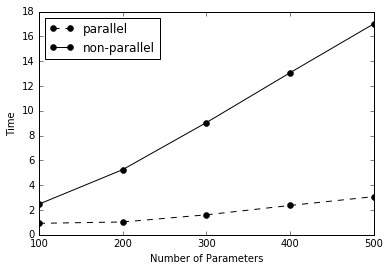

In [19]:
# Create figure.
fig = plt.figure()
ax1 = fig.add_subplot(111)

# Add lines for parallel and non-parallel execution times.
line1 = ax1.plot(parallel,'ko--' ,label='parallel')
line2 = ax1.plot(non_parallel,'ko-',label='non-parallel')

# Adjust plot axes.
ax1.set_xlabel('Number of Parameters')
ax1.set_ylabel('Time')
plt.xticks(range(len(grid)), grid)

# Add a legend.
ax1.legend(loc=2)

fig.savefig('plot.pdf')

We clearly see that the parallel implementation outperforms the non-parallel implementation. This holds true for any number of parameters.